In [1]:
from IPython.display import HTML
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Hide/Show: Raw Code"></form>''')

In [32]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import os

from scipy import stats

from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report


import warnings
warnings.filterwarnings("ignore")

from manny_wrangle import *
from env import *

<img src="title.png" alt="title.png" width="800"/>

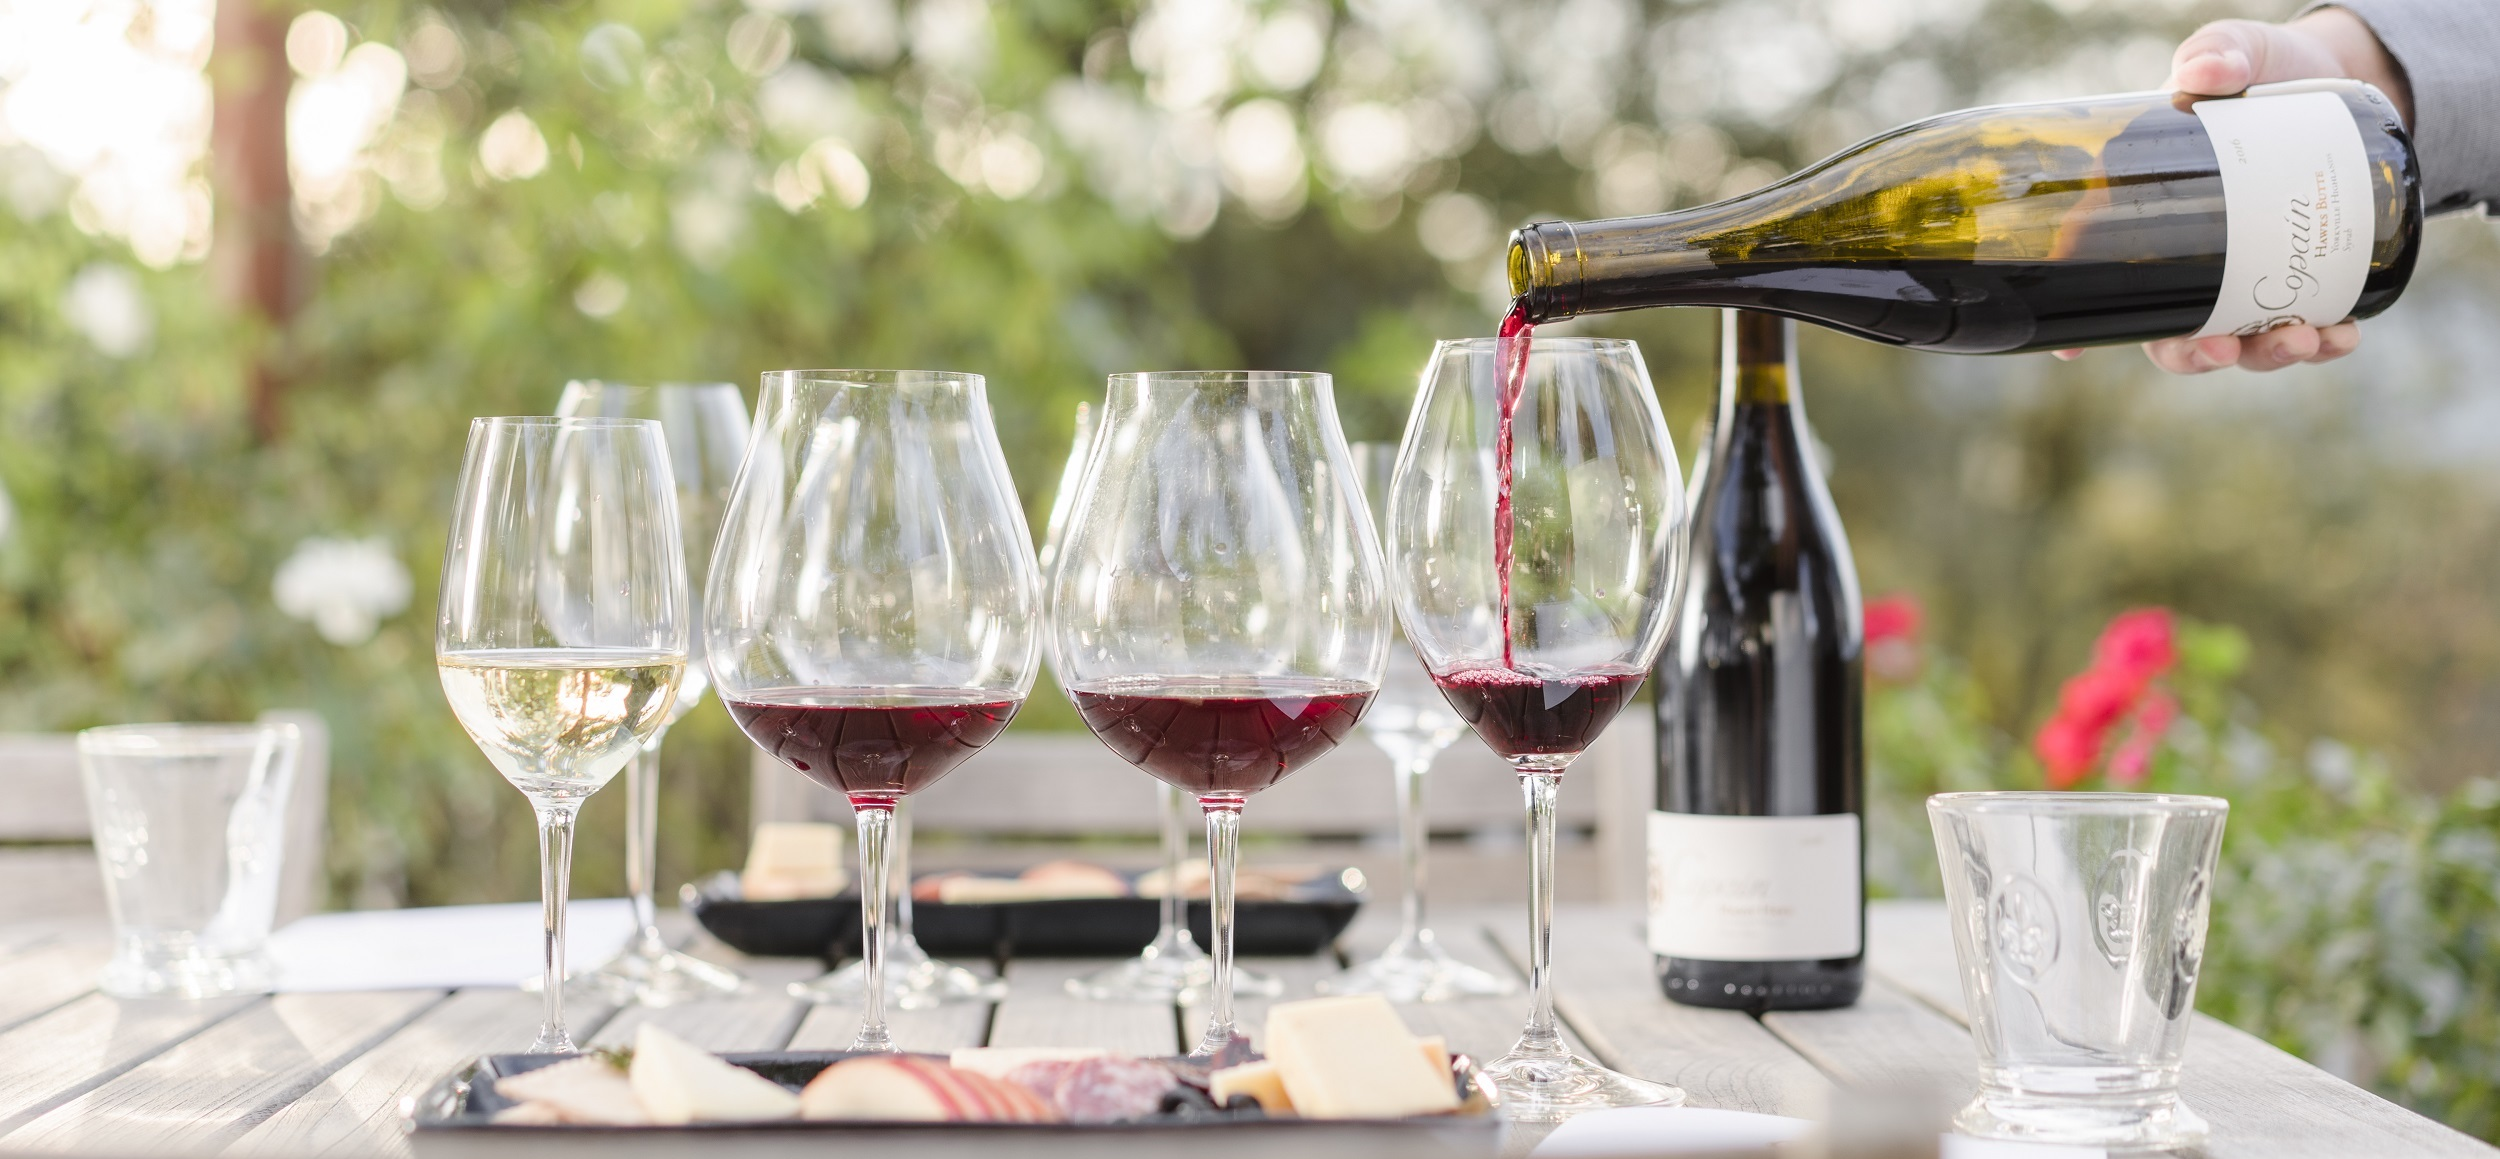

# Acquire

In [33]:
# acquiring data from csv for red & white wines
wine_red = pd.read_csv('winequality-red.csv')
wine_white = pd.read_csv('winequality-white.csv')

### `wine_color` Column

In [34]:
wine_red['wine_color']='red'

In [35]:
wine_white['wine_color']='white'

### Concatenate

In [36]:
frames = [wine_red,wine_white]

In [37]:
wines = pd.concat(frames)

# Cleaning

### Renaming

In [38]:
rename_columns(wines)

In [39]:
wines.reset_index(drop=True)

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,ph,sulphates,alcohol,quality,wine_color
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5,red
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5,red
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5,red
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6,red
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5,red
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6492,6.2,0.21,0.29,1.6,0.039,24.0,92.0,0.99114,3.27,0.50,11.2,6,white
6493,6.6,0.32,0.36,8.0,0.047,57.0,168.0,0.99490,3.15,0.46,9.6,5,white
6494,6.5,0.24,0.19,1.2,0.041,30.0,111.0,0.99254,2.99,0.46,9.4,6,white
6495,5.5,0.29,0.30,1.1,0.022,20.0,110.0,0.98869,3.34,0.38,12.8,7,white


### Types

In [40]:
wines["free_sulfur_dioxide"] = wines["free_sulfur_dioxide"].astype(int)
wines["total_sulfur_dioxide"] = wines["total_sulfur_dioxide"].astype(int)

### Outliers

In [41]:
def remove_outliers(df,col_list,k):
    ''' 
    This function takes in a dataframe, the threshold and a list of columns 
    and returns the dataframe with outliers removed
    '''   
    for col in col_list:

        q1, q3 = df[col].quantile([.25, .75])  # get quartiles
        
        iqr = q3 - q1   # calculate interquartile range
        
        upper_bound = q3 + k * iqr   # get upper bound
        lower_bound = q1 - k * iqr   # get lower bound

        # return dataframe without outliers
        df = df[(df[col] > lower_bound) & (df[col] < upper_bound)]
    return df

In [42]:
col_list = ['fixed_acidity', 'volatile_acidity', 'citric_acid',
                            'residual_sugar', 'chlorides', 'free_sulfur_dioxide',
                            'total_sulfur_dioxide', 'density', 'ph', 'sulphates',
                            'alcohol']

In [43]:
wines = remove_outliers(wines, col_list, k=1.5)

# Model

### Split

In [44]:
def split_data(df, target):
    '''
    This function take in a dataframe performs a train, validate, test split
    Returns train, validate, test, X_train, y_train, X_validate, y_validate, X_test, y_test
    and prints out the shape of train, validate, test
    '''
    #create train_validate and test datasets
    train, test = train_test_split(df, train_size = 0.8, random_state = 123)
    #create train and validate datasets
    train, validate = train_test_split(train, train_size = 0.7, random_state = 123)

    #Split into X and y
    X_train = train.drop(columns=[target])
    y_train = train[target]

    X_validate = validate.drop(columns=[target])
    y_validate = validate[target]

    X_test = test.drop(columns=[target])
    y_test = test[target]

    # Have function print datasets shape
    print(f'train -> {train.shape}')
    print(f'validate -> {validate.shape}')
    print(f'test -> {test.shape}')
   
    return train, validate, test, X_train, y_train, X_validate, y_validate, X_test, y_test

In [45]:
train, validate, test, X_train, y_train, X_validate, y_validate, X_test, y_test = split_data(wines,'quality')

train -> (2548, 13)
validate -> (1092, 13)
test -> (910, 13)


### Dummies

In [46]:
num,cat = separate_column_type_list(train)

In [47]:
to_dummy = ['wine_color']
# Create dummies for non-binart categorical variables
dummies = pd.get_dummies(train[to_dummy], drop_first=False)
train = pd.concat([train, dummies], axis=1)

In [48]:
drop = ['wine_color']
train.drop(columns=drop, inplace=True)

# Baseline

In [49]:
# code to generate baseline 
wines['baseline'] = wines['quality'].value_counts().idxmax()
# clean f string
print(f"Baseline: {(wines['quality'] == wines['baseline']).mean()*100:.2f}%")

Baseline: 45.58%


In [200]:
(wines['quality'] == wines['baseline'])

20       True
25      False
26      False
33       True
37      False
        ...  
4893     True
4894    False
4895     True
4896    False
4897     True
Length: 4550, dtype: bool

In [201]:
plot_baseline = (wines['quality'] == wines['baseline']).mean()*100

# X Dummies

In [50]:
to_dummy = ['wine_color']

In [51]:
# Train
train_dummies = pd.get_dummies(X_train[to_dummy], drop_first=False)
X_train = pd.concat([X_train, train_dummies], axis=1)

# Validate
validate_dummies = pd.get_dummies(X_validate[to_dummy], drop_first=False)
X_validate = pd.concat([X_validate, validate_dummies], axis=1)

# Test
test_dummies = pd.get_dummies(X_test[to_dummy], drop_first=False)
X_test = pd.concat([X_test, test_dummies], axis=1)

In [52]:
# Drop Old
drop = ['wine_color']
X_train.drop(columns=drop, inplace=True)
X_validate.drop(columns=drop, inplace=True)
X_test.drop(columns=drop, inplace=True)

# Random Forest

       train  validate
0   0.464286  0.453297
1   0.496468  0.483516
2   0.539639  0.514652
3   0.572606  0.527473
4   0.598901  0.539377
5   0.633046  0.565934
6   0.676217  0.577839
7   0.717425  0.598901
8   0.772370  0.595238
9   0.808477  0.618132
10  0.855181  0.638278
11  0.895212  0.646520
12  0.925432  0.644689
13  0.939953  0.649267
14  0.952119  0.652930
15  0.965856  0.652015
16  0.967818  0.633700
17  0.976845  0.631868
18  0.976845  0.637363


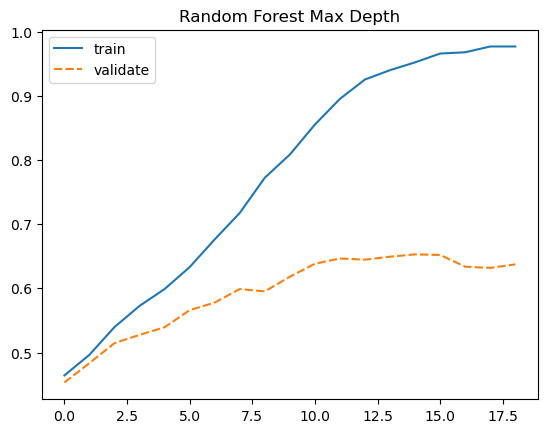

In [318]:
rf_train_scores = []
rf_validate_scores = []
for i in range(1,20):
    loop_forest = RandomForestClassifier(max_depth=i, random_state=42, max_samples=0.5)
    loop_forest.fit(X_train, y_train)
    rf_train_scores.append(loop_forest.score(X_train, y_train))
    rf_validate_scores.append(loop_forest.score(X_validate, y_validate))
rf_scores = {'train':rf_train_scores,'validate':rf_validate_scores}
rf_scores = pd.DataFrame(rf_scores)
print(rf_scores)
sns.lineplot(rf_scores)
plt.title("Random Forest Max Depth")
plt.show()

In [258]:
best_rf = RandomForestClassifier(max_depth=3, random_state=42, max_samples=0.5)
best_rf.fit(X_train, y_train)
best_rf_train_score = best_rf.score(X_train, y_train)
best_rf_validate_score = best_rf.score(X_validate, y_validate)

In [53]:
# random forest algorithm 
rf3 = RandomForestClassifier(max_depth=8, random_state=42,
                            max_samples=0.5)
#fit it 
rf3.fit(X_train, y_train)
# clean f string
print('Random Forest Model')
print(f"Accuracy of Random Forest on train data: {rf3.score(X_train, y_train)}") 
print(f"Accuracy of Random Forest on validate: {rf3.score(X_validate, y_validate)}")

Random Forest Model
Accuracy of Random Forest on train data: 0.717425431711146
Accuracy of Random Forest on validate: 0.5989010989010989


# Logistic Regression Loop Part I

In [112]:
solver_list=['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']

In [144]:
lr_train_scores = []
lr_validate_scores = []
for i in solver_list:
    logit_loop = LogisticRegression(C=.1, random_state=42, 
                           intercept_scaling=1, solver=i)    
    logit_loop.fit(X_train, y_train)
    lr_train_scores.append(logit_loop.score(X_train, y_train))
    lr_validate_scores.append(logit_loop.score(X_validate, y_validate))
lr_scores = {'train':lr_train_scores,'validate':lr_validate_scores,'solver':solver_list}
lr_scores = pd.DataFrame(lr_scores)
print(lr_scores)

      train  validate     solver
0  0.523548  0.517399  newton-cg
1  0.472135  0.469780      lbfgs
2  0.505887  0.499084  liblinear
3  0.480377  0.478938        sag
4  0.472920  0.476190       saga


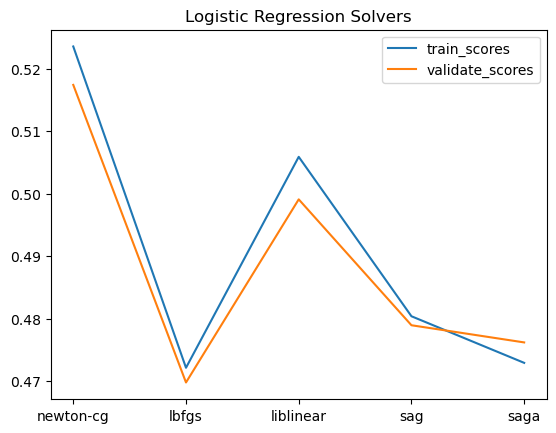

In [145]:
plt.plot(lr_scores['solver'],lr_scores["train"],label='train_scores')
plt.plot(lr_scores['solver'],lr_scores["validate"],label='validate_scores')
plt.legend()
plt.title("Logistic Regression Solvers")
plt.show()

# Logistic Regression Loop Part II

In [147]:
c_values = [100, 10, 1.0, 0.1, 0.01]

In [186]:
lr_2_train_scores = []
lr_2_validate_scores = []
solver_list_names=[]
c_value_list=[]

for i in solver_list:
    for j in c_values:
        logit_loop_2 = LogisticRegression(C=j, random_state=42, 
                               intercept_scaling=1, solver=i)    
        logit_loop_2.fit(X_train, y_train)
        
        lr_2_train_scores.append(logit_loop_2.score(X_train, y_train))
        lr_2_validate_scores.append(logit_loop_2.score(X_validate, y_validate))
        solver_list_names.append(i)
        c_value_list.append(j)
lr_2_scores = {'train':lr_2_train_scores,'validate':lr_2_validate_scores,'solver_list':solver_list_names,'c_values':c_value_list}
lr_2_scores = pd.DataFrame(lr_2_scores)
print(lr_2_scores)

       train  validate solver_list  c_values
0   0.534144  0.532051   newton-cg    100.00
1   0.531790  0.528388   newton-cg     10.00
2   0.529042  0.523810   newton-cg      1.00
3   0.523548  0.517399   newton-cg      0.10
4   0.498823  0.500000   newton-cg      0.01
5   0.471743  0.473443       lbfgs    100.00
6   0.472527  0.472527       lbfgs     10.00
7   0.468995  0.471612       lbfgs      1.00
8   0.472135  0.469780       lbfgs      0.10
9   0.465071  0.469780       lbfgs      0.01
10  0.533359  0.522894   liblinear    100.00
11  0.532182  0.517399   liblinear     10.00
12  0.525903  0.518315   liblinear      1.00
13  0.505887  0.499084   liblinear      0.10
14  0.474490  0.466117   liblinear      0.01
15  0.478414  0.478022         sag    100.00
16  0.478414  0.478022         sag     10.00
17  0.478414  0.478022         sag      1.00
18  0.480377  0.478938         sag      0.10
19  0.475667  0.475275         sag      0.01
20  0.472135  0.476190        saga    100.00
21  0.4721

In [187]:
lr_2_scores["combo"]=lr_2_scores["c_values"].astype(str)

In [188]:
lr_2_scores["combo"]=lr_2_scores["combo"]+' '+lr_2_scores['solver_list']

In [191]:
lr_2_scores["iterations"]=range(1, 1+len(lr_2_scores))

In [192]:
lr_2_scores

,train,validate,solver_list,c_values,combo,iterations
0,0.534144,0.532051,newton-cg,100.00,100.0 newton-cg,1
1,0.531790,0.528388,newton-cg,10.00,10.0 newton-cg,2
2,0.529042,0.523810,newton-cg,1.00,1.0 newton-cg,3
3,0.523548,0.517399,newton-cg,0.10,0.1 newton-cg,4
4,0.498823,0.500000,newton-cg,0.01,0.01 newton-cg,5
5,0.471743,0.473443,lbfgs,100.00,100.0 lbfgs,6
6,0.472527,0.472527,lbfgs,10.00,10.0 lbfgs,7
7,0.468995,0.471612,lbfgs,1.00,1.0 lbfgs,8
8,0.472135,0.469780,lbfgs,0.10,0.1 lbfgs,9
9,0.465071,0.469780,lbfgs,0.01,0.01 lbfgs,10


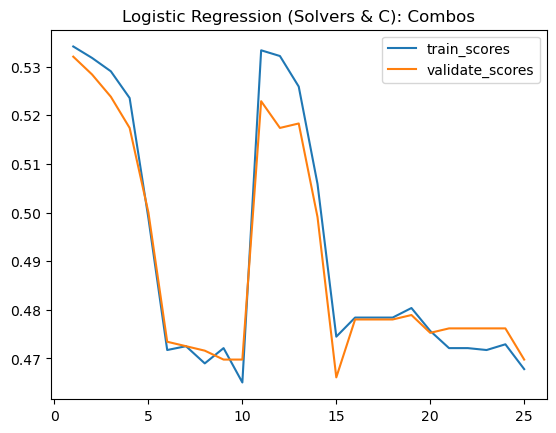

In [193]:
plt.plot(lr_2_scores['iterations'],lr_2_scores["train"],label='train_scores')
plt.plot(lr_2_scores['iterations'],lr_2_scores["validate"],label='validate_scores')
plt.legend()
plt.title("Logistic Regression (Solvers & C): Combos")
plt.show()

# Logistic Regression

In [56]:
# Logistic Regression algorithm
logit2 = LogisticRegression(C=.1, random_state=42, 
                           intercept_scaling=1, solver='lbfgs')

#fit the model
logit2.fit(X_train, y_train)
#clean f string
print('Logistic Regression Model')
print(f"Accuracy of Logistic Regression on train: {logit2.score(X_train, y_train)}") 
print(f"Accuracy of Logistic Regression on validate: {logit2.score(X_validate, y_validate)}")

Logistic Regression Model
Accuracy of Logistic Regression on train: 0.4721350078492936
Accuracy of Logistic Regression on validate: 0.4697802197802198


# KNN

       train  validate
0   1.000000  0.529304
1   0.778650  0.482601
2   0.717033  0.454212
3   0.673469  0.454212
4   0.645212  0.461538
5   0.625589  0.456044
6   0.607143  0.470696
7   0.597331  0.464286
8   0.591052  0.473443
9   0.583203  0.454212
10  0.572606  0.463370
11  0.560832  0.460623
12  0.551020  0.467949
13  0.554945  0.478022
14  0.549843  0.475275
15  0.541601  0.483516
16  0.539246  0.474359
17  0.536892  0.464286
18  0.530612  0.476190
19  0.525903  0.475275
20  0.525510  0.473443
21  0.521193  0.483516
22  0.520408  0.478022
23  0.516876  0.471612
24  0.519623  0.474359
25  0.514129  0.466117
26  0.520801  0.470696
27  0.510597  0.457875
28  0.512166  0.465201
29  0.505495  0.454212


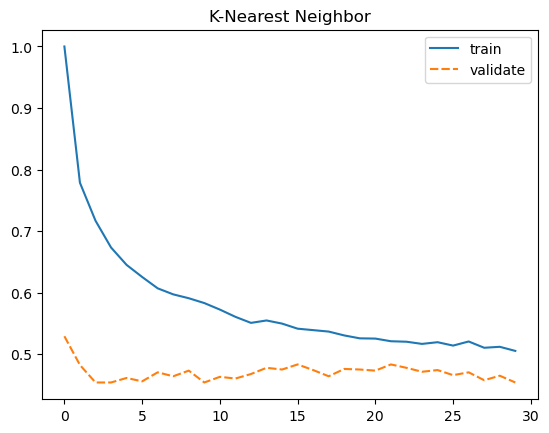

In [139]:
knn_train_scores = []
knn_validate_scores = []
for i in range(1,31):
    knn_loop = KNeighborsClassifier(n_neighbors=i)
    knn_loop.fit(X_train, y_train)
    knn_train_scores.append(knn_loop.score(X_train, y_train))
    knn_validate_scores.append(knn_loop.score(X_validate, y_validate))
knn_scores = {'train':knn_train_scores,'validate':knn_validate_scores}
knn_scores = pd.DataFrame(knn_scores)
print(knn_scores)

sns.lineplot(data=knn_scores)
plt.title("K-Nearest Neighbor")
plt.show()

In [58]:
# K nearest neighbor algorithm

knn3 = KNeighborsClassifier(n_neighbors=3)
knn3.fit(X_train, y_train)
knn3.score(X_train, y_train)
knn3.score(X_validate, y_validate)
# clean f string
print('KNN Model')
print(f"Accuracy of KNN on train: {knn3.score(X_train, y_train)}") 
print(f"Accuracy of KNN on validate: {knn3.score(X_validate, y_validate)}")

KNN Model
Accuracy of KNN on train: 0.717032967032967
Accuracy of KNN on validate: 0.4542124542124542


# Plot Test vs. Baseline

In [207]:
# Recalculating Best Peforming Model with new name
best_model = LogisticRegression(C=100, random_state=42, 
                               intercept_scaling=1, solver="newton-cg")    
best_model.fit(X_train, y_train)
best_model.score(X_test,y_test)

0.5340659340659341

In [231]:
# Baseline
plot_baseline = (wines['quality'] == wines['baseline']).mean()

In [209]:
# Best Performing Model(Logistic Regression Combo{c=100,newton-cg}) Test Score:
best_test_score = best_model.score(X_test,y_test)

In [233]:
# Test Scores: Project Baseline vs Best Model
plot_baseline, best_test_score

(0.45582417582417584, 0.5340659340659341)

In [234]:
# Temporary Dictionary Holding Baseline & Model Test Score
best_model_plot={"Baseline":[plot_baseline], "Test":[best_test_score]}

In [235]:
best_model_plot

{'Baseline': [0.45582417582417584], 'Test': [0.5340659340659341]}

In [236]:
# Converting Temporary Dictionary to DataFrame
best_model_plot = pd.DataFrame(best_model_plot)

In [239]:
best_model_plot

,Baseline,Test
0,0.455824,0.534066


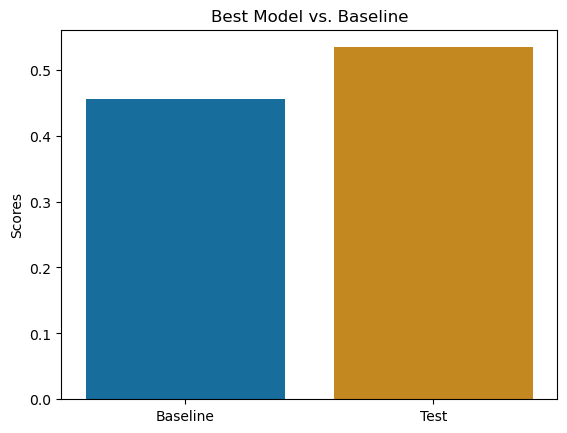

In [247]:
# Visualizing Both Baseline & Model Test Scores

fig=sns.barplot(best_model_plot,palette="colorblind")
plt.title("Best Model vs. Baseline")
fig.set(ylabel='Scores')
plt.show()

# Top Models on Train & Validate Plot

In [264]:
# Best Random Forest
best_rf = RandomForestClassifier(max_depth=3, random_state=42, max_samples=0.5)
best_rf.fit(X_train, y_train)

best_rf_train_score = best_rf.score(X_train, y_train)
best_rf_validate_score = best_rf.score(X_validate, y_validate)

In [323]:
# Best KNN
best_knn = KNeighborsClassifier(n_neighbors=21)
best_knn.fit(X_train, y_train)

best_knn_train_score = best_knn.score(X_train, y_train)
best_knn_validate = best_knn.score(X_validate, y_validate)

In [324]:
# Best Model: Logistic Regression
best_lr1 = LogisticRegression(C=.1, random_state=42,intercept_scaling=1, solver='newton-cg')
best_lr1.fit(X_train, y_train)

best_lr1_train_score = best_lr1.score(X_train, y_train)
best_lr1_validate_score = logit2.score(X_validate, y_validate)

In [325]:
# Best Model: Combo - Logistic Regression
best_lr2 = LogisticRegression(C=100, random_state=42,intercept_scaling=1, solver="newton-cg")    
best_lr2.fit(X_train, y_train)

best_lr2_train_score = best_lr2.score(X_train, y_train)
best_lr2_validate_score = best_lr2.score(X_validate, y_validate)

In [326]:
# lists with model names & score information
best_model_name_list = ["KNN","Random_Forest","Logistic_Regression","Logistic_Regression_Combo"]
best_model_train_scores_list = [best_knn_train_score,best_rf_train_score,best_lr1_train_score,best_lr2_train_score]
best_model_validate_scores_list = [best_knn_validate,best_rf_validate_score,best_lr1_validate_score,best_lr2_validate_score]

In [327]:
# new empty DataFrame
best_scores_df = pd.DataFrame()

In [328]:
# new columns using lists for data
best_scores_df["Model"] = best_model_name_list
best_scores_df["Train_Score"] = best_model_train_scores_list
best_scores_df["Validate_Score"] = best_model_validate_scores_list

In [377]:
melted_scores_df = pd.read_csv('melted_scores_df.csv')  

In [378]:
melted_scores_df

,Model,Score,Type
0,KNN,0.473443,Validate
1,Random_Forest,0.514652,Validate
2,Logistic_Regression,0.469780,Validate
3,Logistic_Regression_Combo,0.532051,Validate
4,KNN,0.525510,Train
5,Random_Forest,0.539639,Train
6,Logistic_Regression,0.523548,Train
7,Logistic_Regression_Combo,0.534144,Train


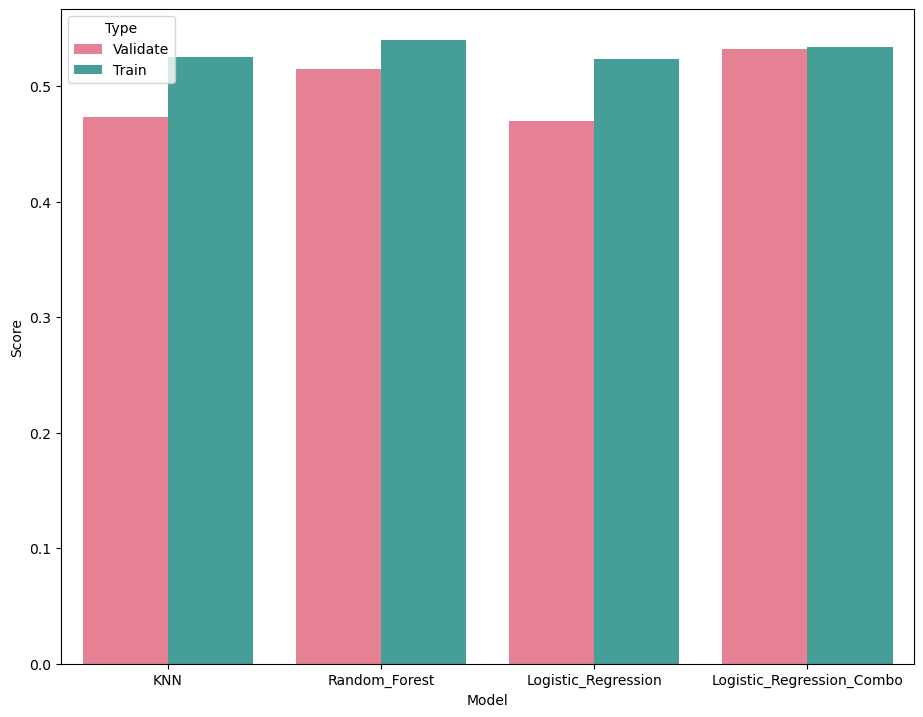

In [392]:
fig = plt.figure(figsize=(11, 8.5))
sns.barplot(data=melted_scores_df,x="Model",y="Score",hue="Type",palette="husl")
plt.show()

---

# Scale

In [ ]:
train_scaled = train[num]

In [ ]:
# Create Object

In [ ]:
mm_scaler = MinMaxScaler()
train_scaled[num] = mm_scaler.fit_transform(train_scaled[num])